## Project Description

With a changing climate the ranges of flora and fauna are also changing. In particular, flat areas, such as those that typify grasslands, are very susceptible to changes in species range change because plants and animals will have to move over long distance to maintain suitable temperatures (Bagne et al., 2012). Additionally, the water supply in these areas are increasingly stressed by higher evaporation and changing rainfall under warmer temperatures. 

In this analysis I assess the changes in habitatbility of two different National Grasslands for Sorghastrum nutans (L.) Nash, a common native grass throughout North America. Using soil pH, elevation, and slope aspect as constants, and varying precipitation, I model the habitability of Pawnee and Cimarron National Grasslands for the years 2050 and 2099 under two different emissions scenarios, scenario 4.5 and 8.5, and compare these to historical habitability in the year 1980. 

S. nutans, also commonly known as Indiangrass, is a warm-season perennial (Braike, 2017). The range of S. nutans is the east coast of the United States, and the species is found throughout the central part of the country but is generally not found west of the Rocky Mounatins except for in Arizona, Utah, Southwest Colorado and New Mexico (Braike, 2017). Indiangrass is typically 1 to 2.5m tall with roots around 60 cm deep and abundant in tallgrass praire ecosystems (USDA, 2017). 

S. nutans requires abundant sunlight and typically grows in areas that recieve 28-114 cm of precipitation annually (Braike, 2017). Indiangrass can grow in a large range of soil pH conditions, ranging from 4.8 to 8, and is adapted to periodic burning in wildfires.

In [1]:
# Import libraries
import logging
import os
from glob import glob

import earthpy as et
import earthpy.appeears as etapp
import folium
import geopandas as gpd
from IPython.display import Image
import math
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import rasterio
import requests
import rioxarray as rxr
import skfuzzy as fuzz
import xarray as xr
import xrspatial
from xrspatial import aspect
import rioxarray.merge as rxrmerge
import warnings

In [2]:
# Display image of Pawnee National Grasslands
snutans_image_url = (
    "https://plants.sc.egov.usda.gov/ImageLibrary/large/sonu2_006_lvp.jpg"
)
Image(url=snutans_image_url)

### Sorghastrum nutans
Image citation: 
Robert H. Mohlenbrock. USDA SCS, 1991, Southern wetland flora: Field office guide to plant species. Provided by USDA NRCS Wetland Science Institute (WSI), Fort Worth.

## Study Areas

Two sites were chosen because of their positions within the current range of Sorghastrum nutan: Pawnee National Grassland is at the western edge of the current range while Cimarron National Grassland is surrounded by areas where S. nutan currently grows.


In [3]:
# Set up logging so AppeearsDownloader will log in notebook
logging.basicConfig(level=logging.INFO)

# Define path to grasslands directory
grasslands_dir = os.path.join(et.io.HOME, et.io.DATA_NAME, 'grassland')

# Define path to data sub-directories
srtm_dir = os.path.join(grasslands_dir, 'srtm')
maca_dir = os.path.join(grasslands_dir, 'maca')

# Create project directories if they don't exist
for a_dir in [grasslands_dir, srtm_dir, maca_dir]:
    if not os.path.exists(a_dir):
        os.makedirs(a_dir)

In [4]:
# Define url for grassland boundary data
grasslands_url = (
    "https://data.fs.usda.gov/geodata/edw/edw_resources"
    "/shp/S_USA.NationalGrassland.zip"
)

# Load grassland boundary data, set index to grassland name,
# and reproject to same coordinate reference system as other data
grasslands_gdf = (
    gpd.read_file(grasslands_url)
    .set_index('GRASSLANDN')
    .to_crs(epsg=4326)
)

In [5]:
# Creata map of national grasslands

# Define coordinates of study areas for plotting
cim_lat = 37.139418
cim_lon = -101.7941457
paw_lat = 40.7614588
paw_lon = -104.0493284

# Create a Folium map object
grassland_map = folium.Map(
    location=[paw_lat, paw_lon],
    zoom_start=5,
    scrollWheelZoom=False
    )

# Create and add title to map
title = "National Grasslands Map"
title_html = (
    f'<h1 style="position:absolute;z-index:100000;left:30vw" >{title}</h1>')
grassland_map.get_root().html.add_child(folium.Element(title_html))

# Define style for grasslands outlines
grassland_style = {
    "fillColor": "maroon",
    "color": "black",
    "weight": 0.5,
}

# Convert the GeoDataFrame to GeoJSON format
grasslands_geojson = grasslands_gdf.to_json()

# Create separate feature groups for tile layers
esri_world_imagery_group = (
    folium
    .FeatureGroup(name='ESRI World Imagery', show=False)
)

# Add ESRI World Imagery as a Tile Layer
esri_world_imagery = folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services"
    "/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    overlay=True,
).add_to(esri_world_imagery_group)

# Add feature groups to the map
esri_world_imagery_group.add_to(grassland_map)

# Add grassland boundaries to map as GeoJSON layer
folium.GeoJson(
    grasslands_geojson,
    name='National Grassland',
    style_function=lambda feature: grassland_style
    ).add_to(grassland_map)

# Add markers for study areas
folium.Marker(
    location=[cim_lat, cim_lon],
    popup='Cimarron National Grassland').add_to(grassland_map)

folium.Marker(
    location=[paw_lat, paw_lon],
    popup='Pawnee National Grassland').add_to(grassland_map)

# Add layer control to toggle between different layers
folium.LayerControl(collapsed=False).add_to(grassland_map)

# Display the map
grassland_map

In [6]:
# Select and save individual grassland boundaries as own geodataframe
cim_gdf = (
    grasslands_gdf[grasslands_gdf.index == 'Cimarron National Grassland'])

paw_gdf = (
    grasslands_gdf[grasslands_gdf.index == 'Pawnee National Grassland'])

Pawnee National Grassland is located in northeastern Colorado and spans 193,060 acres (40.7614588, -104.0493284). No rivers run through the grasslands but water is accessible in shallow aquifers (Franklin et al., 2020). Shales and sandstones underly most of the grasslands, and sandstone make up the two Pawnee Buttes. Grasses dominate the vegetation although there are some shurbs and yucca and cottonwoods are present near springs. Elevation ranges from 4300 to 5900 feet. The average January high temperature is 44 °F and the average low is 17°F (Greeley, CO: NOWData) Summers are hot and dry. July average high and low of 92 and 59°F, respectively. The annual precipitation is 18 inches and mostly falls in spring. The Pawnee National Grasslands are located on the ancestral homelands of the Cheyenne, Arapaho and Očhéthi Šakówiŋ peoples.

Image source: https://upload.wikimedia.org/wikipedia/commons/1/18/Pawnee_Buttes2010.jpg

In [7]:
# Display image of Pawnee National Grasslands
pawnee_image_url = (
    "https://upload.wikimedia.org/wikipedia/commons/1/18/Pawnee_Buttes2010.jpg"
)
Image(url=pawnee_image_url)

In [8]:
# Creata map for Pawnee National Grassland

# Define coordinates of study area for plotting
paw_lat = 40.7614588
paw_lon = -104.0493284

# Create a Folium map object
pawnee_map = folium.Map(
    location=[paw_lat, paw_lon],
    zoom_start=10,
    scrollWheelZoom=False
    )

# Create and add title to map
title = "Pawnee National Grassland Map"
title_html = (
    f'<h1 style="position:absolute;z-index:100000;left:30vw" >{title}</h1>')
pawnee_map.get_root().html.add_child(folium.Element(title_html))

# Define style for grasslands outlines
grassland_style = {
    "fillColor": "maroon",
    "color": "black",
    "weight": 0.5,
}

# Convert the GeoDataFrame to GeoJSON format
paw_geojson = paw_gdf.to_json()

# Create feature group for tile layers
esri_world_imagery_group = (
    folium.FeatureGroup(name='ESRI World Imagery', show=False)
)

# Add ESRI World Imagery as a Tile Layer
esri_world_imagery = folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services"
    "/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    overlay=True,
).add_to(esri_world_imagery_group)

# Add feature group to the map
esri_world_imagery_group.add_to(pawnee_map)

# Add the Pawnee boundary data to the map as a GeoJson layer
folium.GeoJson(
    paw_geojson,
    name='National Grassland',
    style_function=lambda feature: grassland_style
    ).add_to(pawnee_map)

# Add layer control to toggle between different layers
folium.LayerControl(collapsed=False).add_to(pawnee_map)

# Display the map
pawnee_map

Cimarron National Grassland is located in southwestern Kansas (37.139418, -101.7941457) and covers 108,175 acres (Kuhn, 2009). The landscape comprises sandstone and limestone cliffs with shale bedrock underlying low lying areas. Vegetation includes cottonwoods, prairie grasses, yucca and sagebrush. The elevation ranges from 3,150 to 3,540 feet. The Cimarron River provides water to the area and flows through the grasslands but is usually dry above ground late summer through winter. Winter climate is mild to cold with little snowfall. The average January high temperature is 48 °F and the average low is 21°F (Elkhart, KS: NOWData). Summers are hot and dry, with a July average high and low of 94 and 65°F, respectively. The annual precipitation is 15 inches and mostly falls from spring to early fall. The Cimarron National Grasslands are located on the ancestral homelands of the Kiowa, Kansa, Osage, Pawnee, Comanche, Očhéthi Šakówiŋ, Arapaho, and Ute peoples.

Image source: https://www.nps.gov/common/uploads/cropped_image/primary/BC205601-E3B9-0B30-C0C17FD215C27475.jpg?width=1600&quality=90&mode=crop

In [9]:
# Display image of Cimarron National Grasslands
cimarron_image_url = (
    "https://www.nps.gov/common/uploads/cropped_image/primary"
    "/BC205601-E3B9-0B30-C0C17FD215C27475.jpg?width=1600&quality=90&mode=crop"
)
Image(url=cimarron_image_url)

In [10]:
# Define coordinates of study area for plotting
cim_lat = 37.139418
cim_lon = -101.7941457

# Create a Folium map object
cim_map = folium.Map(
    location=[cim_lat, cim_lon],
    zoom_start=10,
    scrollWheelZoom=False
    )

# Create and add title to map
title = "Cimarron National Grassland Map"
title_html = (
    f'<h1 style="position:absolute;z-index:100000;left:30vw" >{title}</h1>')
cim_map.get_root().html.add_child(folium.Element(title_html))

# Define style for grasslands outlines
grassland_style = {
    "fillColor": "maroon",
    "color": "black",
    "weight": 0.5,
}

# Convert the GeoDataFrame to GeoJSON format
cim_geojson = cim_gdf.to_json()

# Create separate feature groups for tile layers
esri_world_imagery_group = (
    folium.FeatureGroup(name='ESRI World Imagery', show=False)
)

# Add ESRI World Imagery as a Tile Layer
esri_world_imagery = folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services"
    "/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    overlay=True,
).add_to(esri_world_imagery_group)

# Add feature groups to the map
esri_world_imagery_group.add_to(cim_map)

# Add grassland boundary to map as GeoJSON layer
folium.GeoJson(
    cim_geojson,
    name='National Grassland',
    style_function=lambda feature: grassland_style
    ).add_to(cim_map)

# Add layer control to toggle between different layers
folium.LayerControl(collapsed=False).add_to(cim_map)

# Display the map
cim_map

## National Grassland Boundary Dataset:
This dataset contains vector data defining the boundary of the National Grasslands within the United States.

### National Grassland Boundaries Citation:
U.S. Forest Service-Geospatial Data Discovery https://data-usfs.hub.arcgis.com/datasets/usfs::original-proclaimed-national-forests-and-national-grasslands-feature-layer/about

## POLARIS dataset:
The POLARIS dataset is a 30m spatial resolution predicted soil map of the United States that contains over 9 billion grid cells. The map was constructed by combing environmental data and a machine learning algorithm and is an improvement over it’s predecessor, the Soil Survey Geographic (SSURGO) database, in that uses predictive modelling to fill in unmapped areas. This dataset includes a number of soil variables, including percentage of silt, sand and clay, bulk density, soil water content, soil pH, organic matter content, and measures of pore size. In this analysis we use mean pH data from 60-100 cm depth. This depth was chosen because it spans the root depth of S. nutans (Macleod, 2017).

### POLARIS citation:
Chaney, N. W., Wood, E. F., McBratney, A. B., Hempel, J. W., Nauman, T. W., Brungard, C. W., & Odgers, N. P. (2016). POLARIS: A 30-meter probabilistic soil series map of the contiguous United States. Geoderma, 274, 54-67.

In [11]:
# Define function to get the bounds of a grassland
# for use in creating urls for pH data download
def calculate_bounds(gdf):
    """
    Calculates the bounds for data download from POLARIS dataset given a gdf.

    Parameters
    ==========
    gdf : gdf
      Input geodataframe

    Returns
    =======
    east_bound : int
      longitude integer to east of eastern-most point in geodataframe
    south_bound : int
      longitude integer to south of southern-most point in geodataframe
    west_bound : int
      longitude integer to west of western-most point in geodataframe
    north_bound : int
      longitude integer to north of northern-most point in geodataframe
    """
    max_lon, min_lat, min_lon, max_lat = map(abs, gdf.total_bounds)
    east_bound = math.floor(min_lon)
    south_bound = math.floor(min_lat)
    west_bound = math.ceil(max_lon)
    north_bound = math.ceil(max_lat)
    return east_bound, south_bound, west_bound, north_bound

In [12]:
# Create list of two grasslands to iterate on
two_grasslands_gdf = [cim_gdf, paw_gdf]

# Define name for each dataframe to make variables
cim_gdf.name = "cim"
paw_gdf.name = "paw"

# Execute function to create variables for bounds of grasslands
for gdf in two_grasslands_gdf:
    east_bound, south_bound, west_bound, north_bound = calculate_bounds(gdf)

    # Use globals() to create global variables dynamically
    globals()[f"{gdf.name}_east_bound"] = east_bound
    globals()[f"{gdf.name}_south_bound"] = south_bound
    globals()[f"{gdf.name}_west_bound"] = west_bound
    globals()[f"{gdf.name}_north_bound"] = north_bound

# Access bounding varibales
# cim_north_bound

In [13]:
# Define function to create urls for pH data download
def generate_pH_urls(south_bound, north_bound, east_bound, west_bound):
    """
    Creates urls for data download from POLARIS dataset:
    mean pH from 60-100cm depth.

    Data citation:
    Chaney, N. W., Wood, E. F., McBratney, A. B., Hempel, J. W., Nauman, T. W.,
    Brungard, C. W., & Odgers, N. P. (2016).
    POLARIS: A 30-meter probabilistic soil series map of the
    contiguous United States. Geoderma, 274, 54-67.

    Parameters
    ==========
    south_bound : int
      longitude integer to south of southern-most point in geodataframe
    north_bound : int
      longitude integer to north of northern-most point in geodataframe
    east_bound : int
      longitude integer to east of eastern-most point in geodataframe
    west_bound : int
      longitude integer to west of western-most point in geodataframe

    Returns
    =======
    ph_urls : list of str variables
      list of urls to use for data downloads
    """
    ph_urls = []

    for lat in range(south_bound, north_bound):
        for lon in range(east_bound + 1, west_bound + 1):
            url = f"http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/60_100/lat{lat}{lat + 1}_lon-{lon}-{lon-1}.tif"
            ph_urls.append(url)

    return ph_urls

In [14]:
# Run generate_pH_urls function on gdf for each grassland
# to create url list for download
cim_ph_urls = generate_pH_urls(cim_south_bound, cim_north_bound,
                               cim_east_bound, cim_west_bound)
paw_ph_urls = generate_pH_urls(paw_south_bound, paw_north_bound,
                               paw_east_bound, paw_west_bound)

In [15]:
# Download pH data from each grassland's url list
cim_ph_das = [rxr.open_rasterio(url, masked=True).squeeze()
              for url in cim_ph_urls]
paw_ph_das = [rxr.open_rasterio(url, masked=True).squeeze()
              for url in paw_ph_urls]

# Merge pH data into one data array for each grassland
cim_merged_ph_da = rxrmerge.merge_arrays(cim_ph_das)
paw_merged_ph_da = rxrmerge.merge_arrays(paw_ph_das)

# Clip the raster data to the bounds of grassland
cim_bound_box = cim_gdf.total_bounds
cim_ph_da = cim_merged_ph_da.rio.clip_box(*cim_bound_box)

paw_bound_box = paw_gdf.total_bounds
paw_ph_da = paw_merged_ph_da.rio.clip_box(*paw_bound_box)

## SRTM elevation dataset:


The Shuttle Radar Topography Mission (SRTM) elevation dataset is near-global set of land elevations, combinging data grom 80% of Earth’s land surface between 60° north and 56° south. SRTM was undertaken on the Endeavor space shuttle in February of 2000 as a collaboration between the National Aeronautics and Space Administration (NASA) and the National Geospatial-Intelligence Agency (NGA). Radar images were taken using  C-band Spaceborne Imaging Radar and the X-Band Synthetic Aperture Radar (X-SAR) hardware, which acquired two signals at slightly different angles different radar antennas—one attached to the shuttle and the other attached to a 60m mast—that enabled surface elevation calculation by computing the difference between the two signals. Data were measured every ~30meters, and displayed in units of meters. In this analysis slope and slope aspect are calculated from this digital elevation model (DEM). Data were accessed through NASA’s Application for Extracting and Exploring Analysis Ready Samples (AppEEARS). Aspect was calculated from DEM.

### SRTM citation:
NASA JPL (2013). NASA Shuttle Radar Topography Mission Global 1 arc second [Data set]. NASA EOSDIS Land Processes Distributed Active Archive Center. Accessed 2023-12-05 from https://doi.org/10.5067/MEaSUREs/SRTM/SRTMGL1.003


In [16]:
# Create function for downloading SRTM data
def download_srtm_data(ea_dir, download_key, product,
                       layer, start_date, end_date, polygon):
    """
    Download SRTM raster elevation data for a given:
    geometry, start date, and end date.

    Data citation:
    NASA JPL (2013).
    NASA Shuttle Radar Topography Mission Global 1 arc second [Data set].
    NASA EOSDIS Land Processes Distributed Active Archive Center.
    Accessed 2023-12-11 from https://doi.org/10.5067/MEaSUREs/SRTM/SRTMGL1.003.

    Data downloaded from NASA AρρEEARS

    Parameters
    ==========
    ea_dir : str
      path to directory where data will be saved
    download_key : str
      The name used to label the download
    product : str
      Data product to download NASA Shuttle Radar Topography Mission 
      Global 1 arc second
    layer : str
      Digital elevation data (DEM) layer to download (meters)
    start_date : str
      The start date as 'MM-DD-YYYY'
    end_date : str
      The end date as 'MM-DD-YYYY'
    polygon : gdf
      Bounds for data donwload

    Returns
    =======
    downloader : earthpy.AppearsDownloader
      Object with information about the download.
    """
    # Define the data directory path
    data_dir = os.path.join(ea_dir, download_key)

    # Check if the download directory exists
    if not os.path.exists(data_dir):
        # If it doesn't exist, create the directory and download files
        os.makedirs(data_dir)
        # Define parameters for data download
        elev_downloader = etapp.AppeearsDownloader(
            ea_dir=ea_dir,
            download_key=download_key,
            product=product,
            layer=layer,
            start_date=start_date,
            end_date=end_date,
            polygon=polygon,
        )
    # Download files
        elev_downloader.download_files()
    else:
        print(f"Data already exists in {data_dir}. Skipping download.")


# Set parameters for srtm elevation download
srtm_dir = srtm_dir
product = "SRTMGL1_NC.003"
layer = "SRTMGL1_DEM"
start_date = "02-11-2000"
end_date = "02-21-2000"
paw_download_key = "pawnee-srtm"
cim_download_key = "cimarron-srtm"

In [17]:
# Download DEM data for each grassland
download_srtm_data(srtm_dir, paw_download_key, product, layer,
                   start_date, end_date, paw_gdf)
download_srtm_data(srtm_dir, cim_download_key, product, layer,
                   start_date, end_date, cim_gdf)

Data already exists in /Users/alexiemillikin/earth-analytics/data/grassland/srtm/pawnee-srtm. Skipping download.
Data already exists in /Users/alexiemillikin/earth-analytics/data/grassland/srtm/cimarron-srtm. Skipping download.


In [18]:
# Process SRTM data to extract elevation data
# Create list of download keys to iterate through data directory paths
download_keys = [paw_download_key, cim_download_key]

# Initialize dictionary for srtm data
all_srtm_data = {}

# Iterate through downloaded data to create
for download_key in download_keys:

    # Create file paths to all .tif files
    srtm_paths = glob(
        os.path.join(srtm_dir, download_key, 'SRTMGL1_NC.003*', '*.tif')
    )

    # Open all raster data and save in list
    srtm_data = [rxr.open_rasterio(srtm_path, masked=True).squeeze()
                 for srtm_path in srtm_paths]

    # Open first element of srtm_data list which contains elevation data
    # Set coordinate reference system
    with rxr.open_rasterio(srtm_paths[0]) as src:
        srtm_data[0].attrs['crs'] = src.rio.crs

    # Save SRTM data in all_srtm_data dictionary
    all_srtm_data[download_key] = srtm_data

# Save elevation DataArrays using the download keys to call element from dict
paw_srtm_data = all_srtm_data[paw_download_key][0]
cim_srtm_data = all_srtm_data[cim_download_key][0]

In [19]:
# Clip elevation data to grassland gdf
cim_elevation_da = cim_srtm_data.rio.clip_box(*cim_bound_box)
paw_elevation_da = paw_srtm_data.rio.clip_box(*paw_bound_box)

## MACAv2 dataset:

The MACA dataset downscales modeled output of many climate variables (temperature, precipitation, humidity, wind, radiation) to a 4km resolution over the continental US. Model outputs come from 20 global climate models (GCMs) that were included in the Coupled Model Inter-Comparison Project 5 (CMIP5) and include historical forcings (1950-2005), and the Representative Concentation Pathways (RCPs) for 2006-2100: RCP 4.5, the low emissions scenario is representative of significant reduction in green house gas emissions, and RCP 8.5, the high emissions scenario. In this study I compare monthly average of daily maximum near-surface air temperature and precipitation for 1980 with projections for 2050 and 2099 for each of these climate scenarios. Model data used are from MRI-CGCM3, which was chosen because of its ability to accurately simulate historical North American climate (Radić & Clarke, 2011). Precipitation is calculated as the monthly aggregate of daily average precipitation in mm and summed for each year chosen.

### MACAv2 citation:

Climate forcings in the MACAv2-METDATA were drawn from a statistical downscaling of global climate model (GCM) data from the Coupled Model Intercomparison Project 5 (CMIP5, Taylor et al. 2010) utilizing a modification of the Multivariate Adaptive Constructed Analogs (MACA, Abatzoglou and Brown, 2012) method with the METDATA (Abatzoglou, 2011) observational dataset as training data.

### MRI-CGCM3 citation:
Yukimoto, S., Adachi, Y., Hosaka, M., Sakami, T., Yoshimura, H., Hirabara, M., ... & Kitoh, A. (2012). A new global climate model of the Meteorological Research Institute: MRI-CGCM3—Model description and basic performance—. 気象集誌. 第 2 輯, 90(0), 23-64.



In [20]:
# Download historical precipitation data
# Define url for historical precipitation data
hist_precip_url = (
    "http://thredds.northwestknowledge.net:8080/thredds/ncss"
    "/agg_macav2metdata_pr_MRI-CGCM3_r1i1p1_"
    "historical_1950_2005_CONUS_monthly.nc"
    "?var=precipitation&disableLLSubset=on&disableProjSubset=on&horizStride=1"
    "&time_start=1980-01-15T00%3A00%3A00Z"
    "&time_end=1980-12-15T00%3A00%3A00Z&timeStride=1&accept=netcdf"
)

# Save the file to maca subfolder
file_path = os.path.join(maca_dir, 'maca.nc')
maca_response = requests.get(hist_precip_url)
with open(file_path, 'wb') as maca_file:
    maca_file.write(maca_response.content)

# Open the NetCDF file and process
maca_ds = xr.open_dataset(file_path)
maca_ds = maca_ds.assign_coords(lon=maca_ds.lon-360)
hist_precip_da = maca_ds.precipitation
hist_precip_da = hist_precip_da.rio.write_crs("epsg:4326", inplace=True)
hist_precip_da = hist_precip_da.rio.set_spatial_dims('lon', 'lat', inplace=True)

# Clip historical precip data to grasslands
cim_hist_precip_da = hist_precip_da.rio.clip_box(*cim_gdf.total_bounds)
paw_hist_precip_da = hist_precip_da.rio.clip_box(*paw_gdf.total_bounds)

# Write crs and calculate yealry precipitation for each DataArray after clip
cim_hist_precip_da = cim_hist_precip_da.sum('time').rio.write_crs(
                                "epsg:4326", inplace=True)
paw_hist_precip_da = paw_hist_precip_da.sum('time').rio.write_crs(
                                "epsg:4326", inplace=True)

In [21]:
# Download and proccess future precipitation data
# Define future climate scenarios and model years
climate_scenarios = ['rcp45_2006_2099', 'rcp85_2006_2099']
abbrev_climate_scenarios = ['r45', 'r85']
years = ['2050', '2099']

# Create an empty dictionary to store precip_dataarrays
precip_dataarrays = {}

# Loop through each climate scenario
for climate_scenario, abbrev_climate_scenario in zip(climate_scenarios, abbrev_climate_scenarios):
    # Loop through each year for the current climate scenario
    for year in years:
        # Construct the URL for the current combination of scenario and year
        precip_url = f"http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_macav2metdata_pr_MRI-CGCM3_r1i1p1_{climate_scenario}_CONUS_monthly.nc?var=precipitation&disableLLSubset=on&disableProjSubset=on&horizStride=1&time_start={year}-01-15T00%3A00%3A00Z&time_end={year}-12-15T00%3A00%3A00Z&timeStride=1&accept=netcdf"

        # Download precipitation data
        filename = f'precip_{climate_scenario}_{year}.nc'
        file_path = os.path.join(maca_dir, filename)
        precip_response = requests.get(precip_url)
        with open(file_path, 'wb') as precip_file:
            precip_file.write(precip_response.content)

        # Open the NetCDF file and process
        precip_ds = xr.open_dataset(file_path)
        precip_ds = precip_ds.assign_coords(lon=precip_ds.lon-360)
        precip_da = precip_ds.precipitation
        precip_da.rio.write_crs("epsg:4326", inplace=True)
        precip_da.rio.set_spatial_dims('lon', 'lat', inplace=True)

        # Store the DataArray in the dictionary with a key
        # based on scenario and year
        key = f"{abbrev_climate_scenario}_{year}"
        precip_dataarrays[key] = precip_da

        # Close the dataset
        precip_ds.close()

# Access the DataArrays stored in the dictionary
# for key, precip_da in precip_dataarrays.items():
#     print(f"DataArray for {key}:\n{precip_da}")

In [22]:
# Create empty dictionaries to store clipped DataArrays
cim_precip_dataarrays = {}
paw_precip_dataarrays = {}

# Loop through each DataArray in the precip_dataarrays dictionary
for key, precip_da in precip_dataarrays.items():
    # Clip to cim_gdf
    cim_clipped_da = precip_da.rio.clip_box(*cim_gdf.total_bounds, cim_gdf.crs)

    # Clip to paw_gdf
    paw_clipped_da = precip_da.rio.clip_box(*paw_gdf.total_bounds, paw_gdf.crs)

    # Store the clipped DataArrays in the dictionaries and calc yearly total
    cim_precip_dataarrays[key] = cim_clipped_da.sum('time').rio.write_crs(
                                    "epsg:4326", inplace=True)
    paw_precip_dataarrays[key] = paw_clipped_da.sum('time').rio.write_crs(
                                    "epsg:4326", inplace=True)

# Access the clipped DataArrays stored in the dictionaries
# for key, cim_clipped_da in cim_precip_dataarrays.items():
#     print(f"Clipped DataArray for {key} (Cimarron):\n{cim_clipped_da}")

# for key, paw_clipped_da in paw_precip_dataarrays.items():
#     print(f"Clipped DataArray for {key} (Pawnee):\n{paw_clipped_da}")

In [23]:
# Save each DataArray outside of dictionary
cim_r45_2050_precip = cim_precip_dataarrays['r45_2050']
cim_r85_2050_precip = cim_precip_dataarrays['r85_2050']
paw_r45_2050_precip = paw_precip_dataarrays['r45_2050']
paw_r85_2050_precip = paw_precip_dataarrays['r85_2050']
cim_r45_2099_precip = cim_precip_dataarrays['r45_2099']
cim_r85_2099_precip = cim_precip_dataarrays['r85_2099']
paw_r45_2099_precip = paw_precip_dataarrays['r45_2099']
paw_r85_2099_precip = paw_precip_dataarrays['r85_2099']

# Process spatial data to match other DataArrays
cim_r45_2050_precip = cim_r45_2050_precip.rename(lat='y', lon='x')
cim_r85_2050_precip = cim_r85_2050_precip.rename(lat='y', lon='x')
paw_r45_2050_precip = paw_r45_2050_precip.rename(lat='y', lon='x')
paw_r85_2050_precip = paw_r85_2050_precip.rename(lat='y', lon='x')
cim_r45_2099_precip = cim_r45_2099_precip.rename(lat='y', lon='x')
cim_r85_2099_precip = cim_r85_2099_precip.rename(lat='y', lon='x')
paw_r45_2099_precip = paw_r45_2099_precip.rename(lat='y', lon='x')
paw_r85_2099_precip = paw_r85_2099_precip.rename(lat='y', lon='x')

In [24]:
# Use reproject_match to match grid squares and spatial refence of all data
# for each grassland

# Reproject elevation data
cim_elevation_da_reprj = cim_elevation_da.rio.reproject_match(cim_ph_da)
paw_elevation_da_reprj = paw_elevation_da.rio.reproject_match(paw_ph_da)

# Reproject historical precip data
cim_hist_precip_da_reprj = cim_hist_precip_da.rio.reproject_match(cim_ph_da)
paw_hist_precip_da_reprj = paw_hist_precip_da.rio.reproject_match(paw_ph_da)

# Reproject future scenario precip data
cim_r45_2050_precip = cim_r45_2050_precip.rio.reproject_match(cim_ph_da)
cim_r85_2050_precip = cim_r85_2050_precip.rio.reproject_match(cim_ph_da)
paw_r45_2050_precip = paw_r45_2050_precip.rio.reproject_match(paw_ph_da)
paw_r85_2050_precip = paw_r85_2050_precip.rio.reproject_match(paw_ph_da)
cim_r45_2099_precip = cim_r45_2099_precip.rio.reproject_match(cim_ph_da)
cim_r85_2099_precip = cim_r85_2099_precip.rio.reproject_match(cim_ph_da)
paw_r45_2099_precip = paw_r45_2099_precip.rio.reproject_match(paw_ph_da)
paw_r85_2099_precip = paw_r85_2099_precip.rio.reproject_match(paw_ph_da)

In [25]:
# Calculate aspect from elevation data
# Intialize dictionary to store aspect results
aspect_results = {}

# Create dictionary with name and Data Array to iterate on
elev_das = {'cim': cim_elevation_da_reprj, 'paw': paw_elevation_da_reprj}

# For each grassland's elevation DataArray calculate aspect and save
for name, elev_da in elev_das.items():
    # Calculate aspect using xrspatial.aspect
    aspect_da = xrspatial.aspect(elev_da)

    # Store the calculated aspect in the dictionary
    aspect_results[name + '_aspect'] = aspect_da

# Save each aspect DataArray outside of dictionary
cim_aspect_da = aspect_results['cim_aspect']
paw_aspect_da = aspect_results['paw_aspect']

In [26]:
# Function to plot habitability and underlying data
def plot_habitability(ax, data, title, cmap, cbar_label=None, vmin=None, vmax=None):
    '''
    Creates plot given axes, data, and title.

    Parameters
    ==========
    ax : axes object
      Axes for displaying plot
    data : DataArray
      Input DataArray of environmental variable or habitability
    title : str
      Title of plot
    cmap : str
      Defines colorbar cmap with normal cmap options compatible with matplotlib
    cbar_label : str
      Label for the colorbar (include units here)
    vmin : float
      Defines minimum value for colorbar
    vmas : float
          Defines maximum value for colorbar

    Returns
    =======
    im : plot
      Plot of DataArray
    '''
    im = data.plot.imshow(ax=ax, cmap=cmap, add_colorbar=False, vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.05, aspect=40)
    cbar.set_label(cbar_label)
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_aspect('equal')
    return im

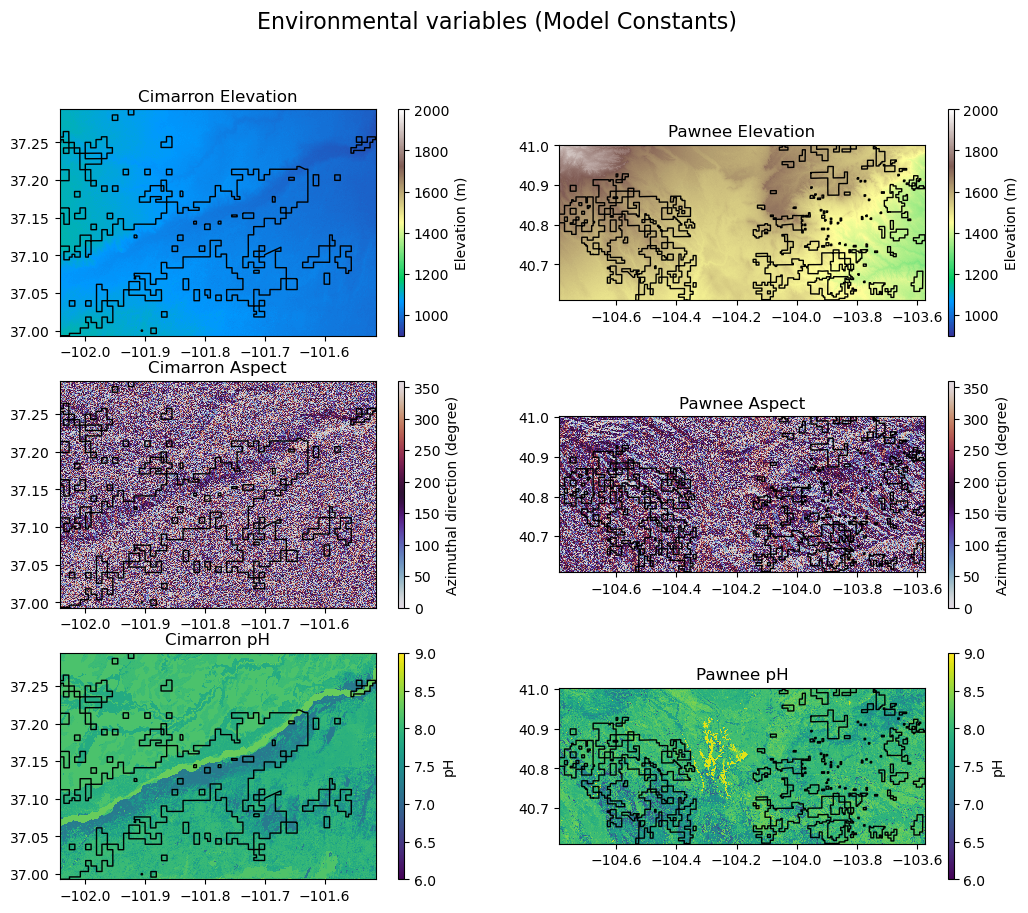

In [27]:
# Create the subplot grid
fig, axs = plt.subplots(3, 2, figsize=(13, 10))
fig.suptitle('Environmental variables (Model Constants)', fontsize=16)

# Plot elevation data in the first row
im_cim_elev = plot_habitability(axs[0, 0], cim_elevation_da_reprj, 'Cimarron Elevation', 'terrain', 'Elevation (m)', vmin=900, vmax=2000)
cim_gdf.plot(ax=axs[0, 0], facecolor='none', edgecolor='black', linewidth=1)

im_paw_elev = plot_habitability(axs[0, 1], paw_elevation_da_reprj, 'Pawnee Elevation', 'terrain', 'Elevation (m)', vmin=900, vmax=2000)
paw_gdf.plot(ax=axs[0, 1], facecolor='none', edgecolor='black', linewidth=1)

# Plot aspect data in the second row
im_cim_aspect = plot_habitability(axs[1, 0], cim_aspect_da, 'Cimarron Aspect', 'twilight', 'Azimuthal direction (degree)', vmin=0, vmax=360)
cim_gdf.plot(ax=axs[1, 0], facecolor='none', edgecolor='black', linewidth=1)

im_paw_aspect = plot_habitability(axs[1, 1], paw_aspect_da, 'Pawnee Aspect', 'twilight', 'Azimuthal direction (degree)', vmin=0, vmax=360)
paw_gdf.plot(ax=axs[1, 1], facecolor='none', edgecolor='black', linewidth=1)

# Plot pH data in the third row
im_cim_ph = plot_habitability(axs[2, 0], cim_ph_da, 'Cimarron pH', 'viridis', 'pH', vmin=6, vmax=9)
cim_gdf.plot(ax=axs[2, 0], facecolor='none', edgecolor='black', linewidth=1)

im_paw_ph = plot_habitability(axs[2, 1], paw_ph_da, 'Pawnee pH', 'viridis', 'pH', vmin=6, vmax=9)
paw_gdf.plot(ax=axs[2, 1], facecolor='none', edgecolor='black', linewidth=1)

# Show the plot
plt.show()

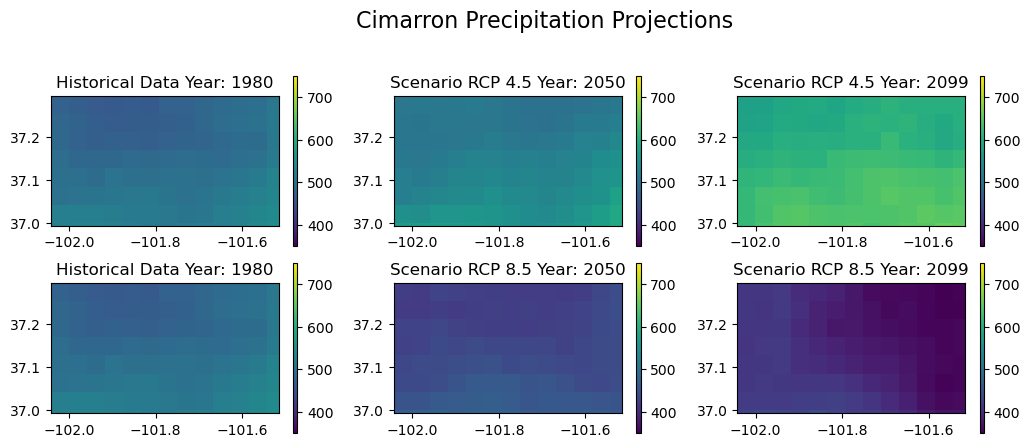

In [29]:
# Read the habitability data
historical_data = xr.DataArray(cim_hist_precip_da_reprj)
rcp45_2050_data = xr.DataArray(cim_r45_2050_precip)
rcp85_2050_data = xr.DataArray(cim_r85_2050_precip)
rcp45_2099_data = xr.DataArray(cim_r45_2099_precip)
rcp85_2099_data = xr.DataArray(cim_r85_2099_precip)

# Create subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(11, 4.5))

# Plot data and collect the last image for color bar
last_im = None
for i in range(2):
    for j in range(3):
        data = None
        title = None
        if j == 0:
            data = historical_data
            title = f'Historical Data Year: 1980'
        elif j == 1:
            data = rcp45_2050_data if i == 0 else rcp85_2050_data
            title = f'Scenario RCP 4.5 Year: 2050' if i == 0 else f'Scenario RCP 8.5 Year: 2050'
        elif j == 2:
            data = rcp45_2099_data if i == 0 else rcp85_2099_data
            title = f'Scenario RCP 4.5 Year: 2099' if i == 0 else f'Scenario RCP 8.5 Year: 2099'

        im = plot_habitability(axs[i, j], data, title, 'viridis', vmin=350, vmax=750)
        last_im = im

# Use the last subplot's axis to get the figure
fig1 = axs[1, 2].get_figure()

# Add an overall title
fig.suptitle('Cimarron Precipitation Projections', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.95, 0.95])

# Show the plot
plt.show()

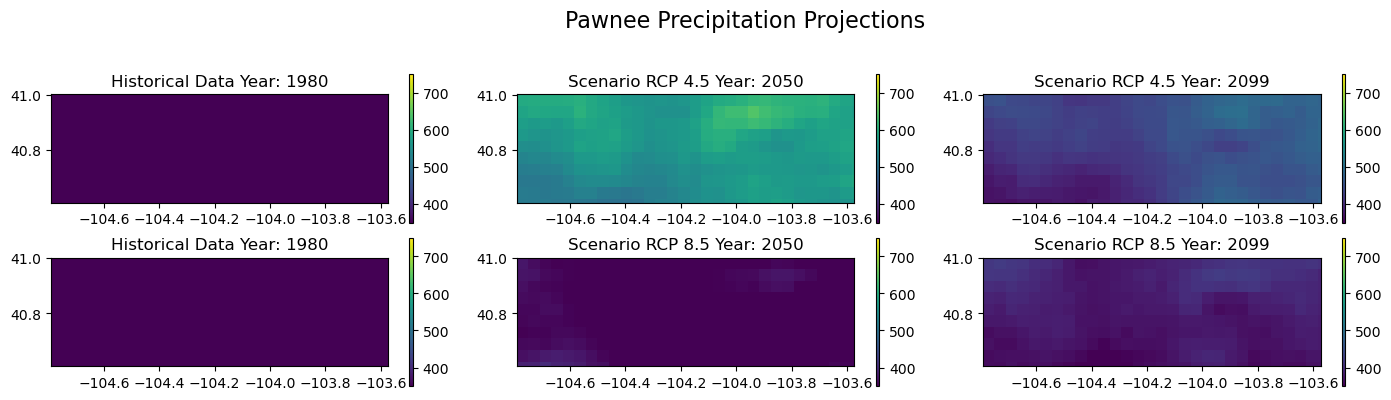

In [30]:
# Read the habitability data
historical_data = xr.DataArray(paw_hist_precip_da_reprj)
rcp45_2050_data = xr.DataArray(paw_r45_2050_precip)
rcp85_2050_data = xr.DataArray(paw_r85_2050_precip)
rcp45_2099_data = xr.DataArray(paw_r45_2099_precip)
rcp85_2099_data = xr.DataArray(paw_r85_2099_precip)

# Create subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 4))

# Plot data and collect the last image for color bar
last_im = None
for i in range(2):
    for j in range(3):
        data = None
        title = None
        if j == 0:
            data = historical_data
            title = f'Historical Data Year: 1980'
        elif j == 1:
            data = rcp45_2050_data if i == 0 else rcp85_2050_data
            title = f'Scenario RCP 4.5 Year: 2050' if i == 0 else f'Scenario RCP 8.5 Year: 2050'
        elif j == 2:
            data = rcp45_2099_data if i == 0 else rcp85_2099_data
            title = f'Scenario RCP 4.5 Year: 2099' if i == 0 else f'Scenario RCP 8.5 Year: 2099'

        im = plot_habitability(axs[i, j], data, title, 'viridis', vmin=350, vmax=750)
        last_im = im

# Use the last subplot's axis to get the figure
fig1 = axs[1, 2].get_figure()

# Add an overall title
fig.suptitle('Pawnee Precipitation Projections', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.95, 0.95])

# Show the plot
plt.show()

## Model Description
A fuzzy logic model was used to calculate the habitability of grid squares in and around the grasslands for different years and climate scenatios. This model was built using the sckikit-fuzzy library.

First, a function (calculate_suitability_da) is used to calculate a trapezoidal membership function for each environmental variable (elevation, ph, aspect, and precipitation) based on assigned ideal values and acceptable ranges (widths) for each variable. An evnironmental DataArray is input, each grid cell is assigned a value between 0 and 1 based on the the membership function, and a resulting suitability DataArray is created.

The graphs below show the membership functions for each environmental variable. Ideal values and ranges were chosen to correspond with the necesary conditions for S. nutans growth, including a pH range from 4.8 to 8, abundant sunlight (most readily achieved on south-facing slopes in the northern hemisphere), and an annual precipitation between 280 and 1140 mm. Additionally, in its current range S. nutans rarely grows in locations with elevations exceeding 1500m.

A mean of the individual membership values for each environmental variable is calculated for each grid square to generate an overall habitability. 

In [31]:
# Define parameters for model

# Define ideal values for each environmental variable
ideal_ph = 6.4
ideal_elevation = 900
ideal_precipitation = 710
ideal_aspect = 180

# Specify widths for each variable
width_ph = 2
width_elevation = 900
width_precipitation = 400
width_aspect = 40

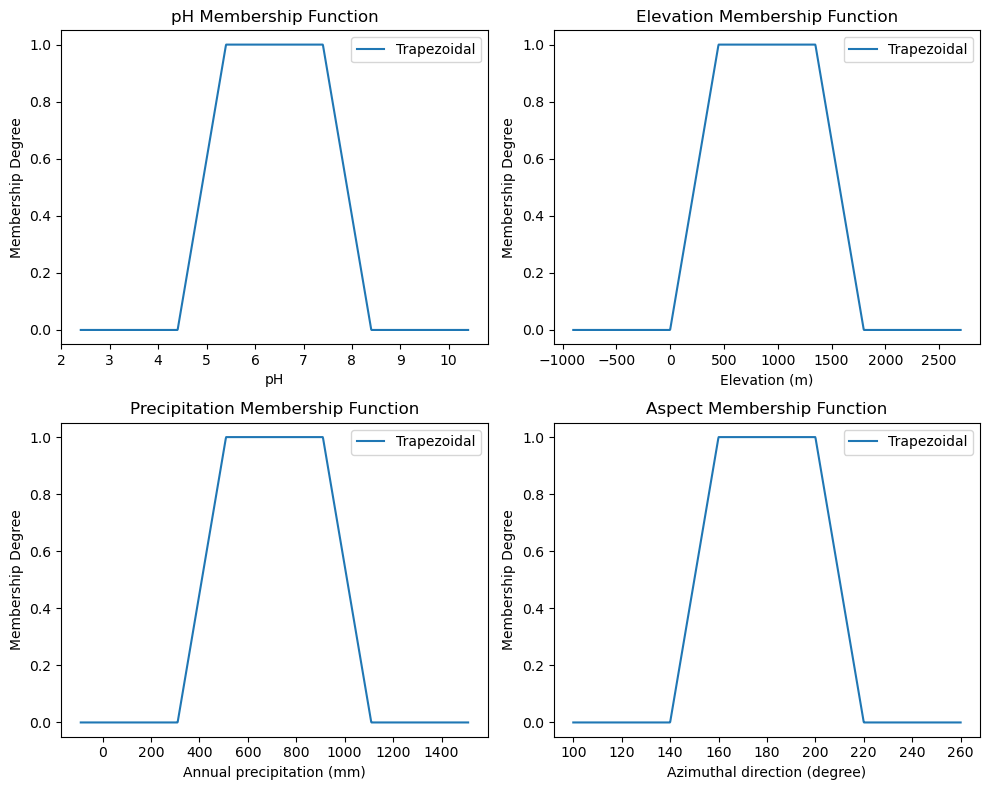

In [32]:
# Generate sample data
ph_ex_data = np.linspace(ideal_ph - 2
                            * width_ph, ideal_ph + 2
                            * width_ph, 1000)
elevation_ex_data = np.linspace(ideal_elevation - 2
                            * width_elevation, ideal_elevation + 2
                            * width_elevation, 1000)
precip_ex_data = np.linspace(ideal_precipitation - 2
                            * width_precipitation, ideal_precipitation + 2
                            * width_precipitation, 1000)
aspect_ex_data = np.linspace(ideal_aspect - 2
                            * width_aspect, ideal_aspect + 2
                            * width_aspect, 1000)

# Calculate trapezoidal membership function
ph_membership = fuzz.trapmf(
    ph_ex_data, [ideal_ph - width_ph, ideal_ph - 0.5
                     * width_ph, ideal_ph + 0.5
                     * width_ph, ideal_ph + width_ph])
elevation_membership = fuzz.trapmf(
    elevation_ex_data,[ideal_elevation - width_elevation, ideal_elevation - 0.5
                       * width_elevation, ideal_elevation + 0.5
                       * width_elevation, ideal_elevation + width_elevation])
precipitation_membership = fuzz.trapmf(
    precip_ex_data,
        [ideal_precipitation - width_precipitation, ideal_precipitation - 0.5
                * width_precipitation, ideal_precipitation + 0.5
                * width_precipitation, ideal_precipitation + width_precipitation])
aspect_membership = fuzz.trapmf(
    aspect_ex_data,
            [ideal_aspect - width_aspect, ideal_aspect - 0.5
                             * width_aspect, ideal_aspect + 0.5
                             * width_aspect, ideal_aspect + width_aspect])

# Create figure
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot each membership function in a subplot
axs[0, 0].plot(ph_ex_data, ph_membership, label='Trapezoidal')
axs[0, 0].set_title('pH Membership Function')
axs[0, 0].set_xlabel('pH')
axs[0, 0].set_ylabel('Membership Degree')
axs[0, 0].legend()

axs[0, 1].plot(elevation_ex_data, elevation_membership, label='Trapezoidal')
axs[0, 1].set_title('Elevation Membership Function')
axs[0, 1].set_xlabel('Elevation (m)')
axs[0, 1].set_ylabel('Membership Degree')
axs[0, 1].legend()

axs[1, 0].plot(precip_ex_data, precipitation_membership, label='Trapezoidal')
axs[1, 0].set_title('Precipitation Membership Function')
axs[1, 0].set_xlabel('Annual precipitation (mm)')
axs[1, 0].set_ylabel('Membership Degree')
axs[1, 0].legend()

axs[1, 1].plot(aspect_ex_data, aspect_membership, label='Trapezoidal')
axs[1, 1].set_title('Aspect Membership Function')
axs[1, 1].set_xlabel('Azimuthal direction (degree)')
axs[1, 1].set_ylabel('Membership Degree')
axs[1, 1].legend()

plt.tight_layout()

# Show figure
plt.show()

In [33]:
def calculate_suitability_da(da, ideal_value, width):
    '''
    Calculates the trapezoidal membership function for a variable 
    using the scikit-fuzzy library.

    Parameters
    ==========
    da : DataArray
      Input DataArray of environmental variable
    ideal_value : float
      Center value of trapezoidal membership function
    width : float
      Width of trapezoidal membership function

    Returns
    =======
    membership_da : DataArray
      DataArray of calculated membership function value with same coordinates
      and dimenstions to the input
    '''
    # Check if the dimension size is greater than 0
    if da.size == 0:
        return xr.zeros_like(da)

    # Calculate the trapezoidal membership function
    membership = fuzz.trapmf(da.values.flatten(),
                             [ideal_value - width, ideal_value - 0.5 * width,
                              ideal_value + 0.5 * width,
                              ideal_value + width])

    # Reshape the result back to the original shape
    membership_da = membership.reshape(da.shape)
    return xr.DataArray(membership_da, coords=da.coords, dims=da.dims)

In [34]:
# Calculate habitability for Cimarron
# Load model constants
ph_data = cim_ph_da
elevation_data = cim_elevation_da_reprj
aspect_data = cim_aspect_da

# Create lists of model scenarios
precip_ls = [cim_hist_precip_da_reprj, cim_r45_2050_precip,
             cim_r85_2050_precip, cim_r45_2099_precip, cim_r85_2099_precip]
names = ["cim_his", "cim_r45_2050",
         "cim_r85_2050", "cim_r45_2099", "cim_r85_2099"]

# Create a dictionary to store the results
cim_habitat_suitability_dict = {}

# Iterate over model scenarios to calculate habitability
for precipitation_data, name in zip(precip_ls, names):
    # Calculate the membership function for each variable
    ph_membership_da = calculate_suitability_da(
        ph_data, ideal_ph, width_ph)
    precip_membership_da = calculate_suitability_da(
        precipitation_data, ideal_precipitation, width_precipitation)
    elevation_membership_da = calculate_suitability_da(
        elevation_data, ideal_elevation , width_elevation)
    apect_membership_da = calculate_suitability_da(
        aspect_data, ideal_aspect, width_aspect)

    # Calculate the overall habitat suitability
    cim_habitat_suitability_dict[name] = (
        ph_membership_da
        + precip_membership_da
        + elevation_membership_da
        + apect_membership_da) / 4

    # # Plot individual membership functions and precipitation for each scenario
    # # to check that model is working
    # # Plot the membership functions for each variable
    # fig, axs = plt.subplots(2, 3, figsize=(15, 6))
    # fig.suptitle(f'Model Run: {name}', fontsize=16)

    # # Plot for pH
    # cbar = axs[0, 0].imshow(ph_membership_da.values,
    #                         cmap='viridis',
    #                         interpolation='none',
    #                         vmin=0, vmax=1)
    # axs[0, 0].set_title('pH Membership Function')
    # plt.colorbar(cbar, ax=axs[0, 0], orientation='vertical')

    # # Plot for Elevation
    # cbar = axs[0, 1].imshow(elevation_membership_da.values,
    #                         cmap='viridis',
    #                         interpolation='none',
    #                         vmin=0, vmax=1)
    # axs[0, 1].set_title('Elevation Membership Function')
    # plt.colorbar(cbar, ax=axs[0, 1], orientation='vertical')

    # # Plot for Aspect
    # cbar = axs[0, 2].imshow(apect_membership_da.values,
    #                         cmap='viridis',
    #                         interpolation='none',
    #                         vmin=0, vmax=1)
    # axs[0, 2].set_title('Aspect Membership Function')
    # plt.colorbar(cbar, ax=axs[0, 2], orientation='vertical')

    # # Plot for Precipitation
    # cbar = axs[1, 0].imshow(precip_membership_da.values,
    #                         cmap='viridis',
    #                         interpolation='none',
    #                         vmin=0, vmax=1)
    # axs[1, 0].set_title('Precipitation Membership Function')
    # plt.colorbar(cbar, ax=axs[1, 0], orientation='vertical')

    # # Plot for Precipitation
    # cbar = axs[1, 1].imshow(precipitation_data.values,
    #                         cmap='viridis',
    #                         interpolation='none',
    #                         vmin=300, vmax=700)
    # axs[1, 1].set_title('Precipitation (mm/yr)')
    # plt.colorbar(cbar, ax=axs[1, 1], orientation='vertical')

    # # Plot the overall habitat suitability
    # cbar = axs[1, 2].imshow(cim_habitat_suitability_dict[name].values,
    #                         cmap='viridis',
    #                         interpolation='none',
    #                         vmin=0, vmax=1)
    # axs[1, 2].set_title('Overall Habitat Suitability')
    # plt.colorbar(cbar, ax=axs[1, 2], orientation='vertical')

    # # Show the plot
    # plt.show()

In [35]:
# Calculate habitability for Cimarron
# Load model constants
ph_data = paw_ph_da
elevation_data = paw_elevation_da_reprj
aspect_data = paw_aspect_da

# Create lists of model scenarios
precip_ls = [paw_hist_precip_da_reprj, paw_r45_2050_precip, paw_r85_2050_precip, paw_r45_2099_precip, paw_r85_2099_precip]
names = ["paw_his", "paw_r45_2050", "paw_r85_2050", "paw_r45_2099", "paw_r85_2099"]

# Create a dictionary to store the results
paw_habitat_suitability_dict = {}

# Iterate over model scenarios to calculate habitability
for precipitation_data, name in zip(precip_ls, names):
    # Calculate the membership function for each variable
    ph_membership_da = calculate_suitability_da(
        ph_data, ideal_ph, width_ph)
    precip_membership_da = calculate_suitability_da(
        precipitation_data, ideal_precipitation, width_precipitation)
    elevation_membership_da = calculate_suitability_da(
        elevation_data, ideal_elevation , width_elevation)
    apect_membership_da = calculate_suitability_da(
        aspect_data, ideal_aspect, width_aspect)

# Calculate the overall habitat suitability
    paw_habitat_suitability_dict[name] = (
        ph_membership_da
        + precip_membership_da
        + elevation_membership_da
        + apect_membership_da) / 4

    # # Plot individual membership functions and precipitation for each scenario
    # # to check that model is working
    # # Plot the membership functions for each variable
    # fig, axs = plt.subplots(2, 3, figsize=(15, 5))
    # fig.suptitle(f'Model Run: {name}', fontsize=16)

    # # Plot for pH
    # cbar = axs[0, 0].imshow(ph_membership_da.values,
    #                         cmap='viridis',
    #                         interpolation='none',
    #                         vmin=0, vmax=1)
    # axs[0, 0].set_title('pH Membership Function')
    # plt.colorbar(cbar, ax=axs[0, 0], orientation='vertical')

    # # Plot for Elevation
    # cbar = axs[0, 1].imshow(elevation_membership_da.values,
    #                         cmap='viridis',
    #                         interpolation='none',
    #                         vmin=0, vmax=1)
    # axs[0, 1].set_title('Elevation Membership Function')
    # plt.colorbar(cbar, ax=axs[0, 1], orientation='vertical')

    # # Plot for Aspect
    # cbar = axs[0, 2].imshow(apect_membership_da.values,
    #                         cmap='viridis',
    #                         interpolation='none',
    #                         vmin=0, vmax=1)
    # axs[0, 2].set_title('Aspect Membership Function')
    # plt.colorbar(cbar, ax=axs[0, 2], orientation='vertical')

    # # Plot for Precipitation
    # cbar = axs[1, 0].imshow(precip_membership_da.values,
    #                         cmap='viridis',
    #                         interpolation='none',
    #                         vmin=0, vmax=1)
    # axs[1, 0].set_title('Precipitation Membership Function')
    # plt.colorbar(cbar, ax=axs[1, 0], orientation='vertical')

    # # Plot for Precipitation
    # cbar = axs[1, 1].imshow(precipitation_data.values,
    #                         cmap='viridis',
    #                         interpolation='none',
    #                         vmin=300, vmax=700)
    # axs[1, 1].set_title('Precipitation (mm/yr)')
    # plt.colorbar(cbar, ax=axs[1, 1], orientation='vertical')

    # # Plot the overall habitat suitability
    # cbar = axs[1, 2].imshow(paw_habitat_suitability_dict[name].values,
    #                         cmap='viridis',
    #                         interpolation='none',
    #                         vmin=0, vmax=1)
    # axs[1, 2].set_title('Overall Habitat Suitability')
    # plt.colorbar(cbar, ax=axs[1, 2], orientation='vertical')

    # # Show the plot
    # plt.show()

## Based on soil pH, elevation slope aspect and projected annual precipitation, the habitability of Cimarron National Grassland for S. nutans will largely remain unchanged under emissions scenario RCP 4.5 but will significantly decrease with time under emissions scenario RCP 8.5.

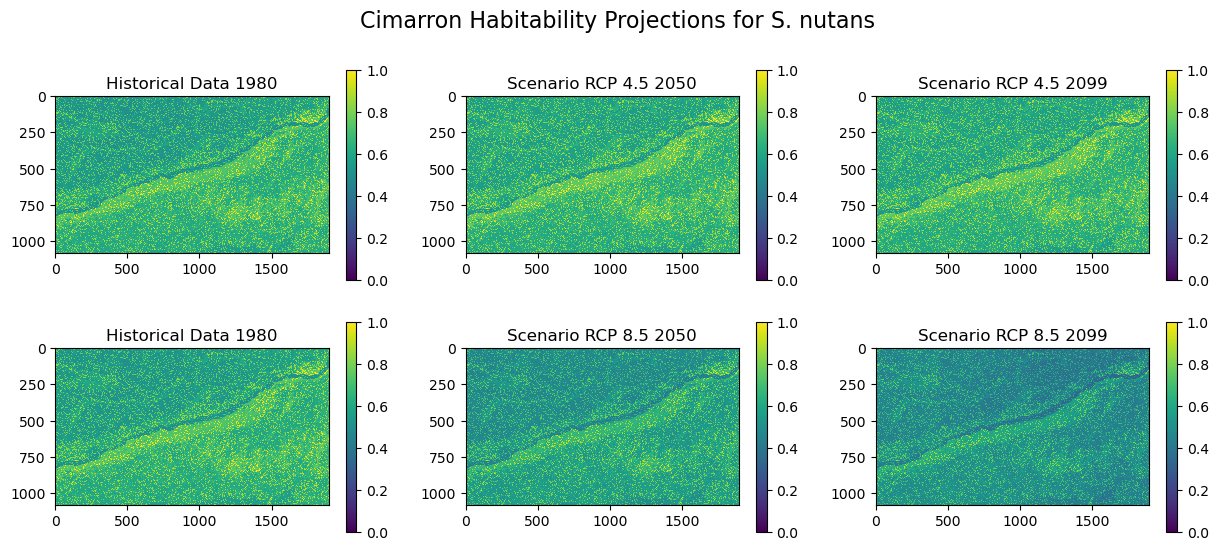

In [36]:
# Read the habitability data for Cimarron
historical_data = cim_habitat_suitability_dict["cim_his"]
rcp45_2050_data = cim_habitat_suitability_dict["cim_r45_2050"]
rcp85_2050_data = cim_habitat_suitability_dict["cim_r85_2050"]
rcp45_2099_data = cim_habitat_suitability_dict["cim_r45_2099"]
rcp85_2099_data = cim_habitat_suitability_dict["cim_r85_2099"]

# Create subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 6))
fig.suptitle('Cimarron Habitability Projections for S. nutans', fontsize=16)

# Plot historical data
cbar = axs[0, 0].imshow(historical_data.values,
                        cmap='viridis',
                        interpolation='none',
                        vmin=0, vmax=1)
axs[0, 0].set_title('Historical Data 1980')
plt.colorbar(cbar, ax=axs[0, 0], orientation='vertical')

# Plot rcp4.5 data for 2050
cbar = axs[0, 1].imshow(rcp45_2050_data.values,
                        cmap='viridis',
                        interpolation='none',
                        vmin=0, vmax=1)
axs[0, 1].set_title('Scenario RCP 4.5 2050')
plt.colorbar(cbar, ax=axs[0, 1], orientation='vertical')

# Plot rcp4.5 data for 2099
cbar = axs[0, 2].imshow(rcp45_2099_data.values,
                        cmap='viridis',
                        interpolation='none',
                        vmin=0, vmax=1)
axs[0, 2].set_title('Scenario RCP 4.5 2099')
plt.colorbar(cbar, ax=axs[0, 2], orientation='vertical')

# Plot historical data
cbar = axs[1, 0].imshow(historical_data.values,
                        cmap='viridis',
                        interpolation='none',
                        vmin=0, vmax=1)
axs[1, 0].set_title('Historical Data 1980')
plt.colorbar(cbar, ax=axs[1, 0], orientation='vertical')

# Plot rcp8.5 data for 2050
cbar = axs[1, 1].imshow(rcp85_2050_data.values, cmap='viridis',
                        interpolation='none',
                        vmin=0, vmax=1)
axs[1, 1].set_title('Scenario RCP 8.5 2050')
plt.colorbar(cbar, ax=axs[1, 1], orientation='vertical')

# Plot rcp8.5 data for 2099
cbar = axs[1, 2].imshow(rcp85_2099_data.values, cmap='viridis',
                        interpolation='none',
                        vmin=0, vmax=1)
axs[1, 2].set_title('Scenario RCP 8.5 2099')
plt.colorbar(cbar, ax=axs[1, 2], orientation='vertical')

# Show the plot
plt.show()

## The habitability of Pawnee National Grassland for S. nutans is projected to increase significantly under emissions scenario RCP 4.5 on short timescales and then decrease modestly with the result still being a more habitable area. Under RCP 8.5 the habitability of Pawnee National Grassland will steadily increase by a more modest degree.

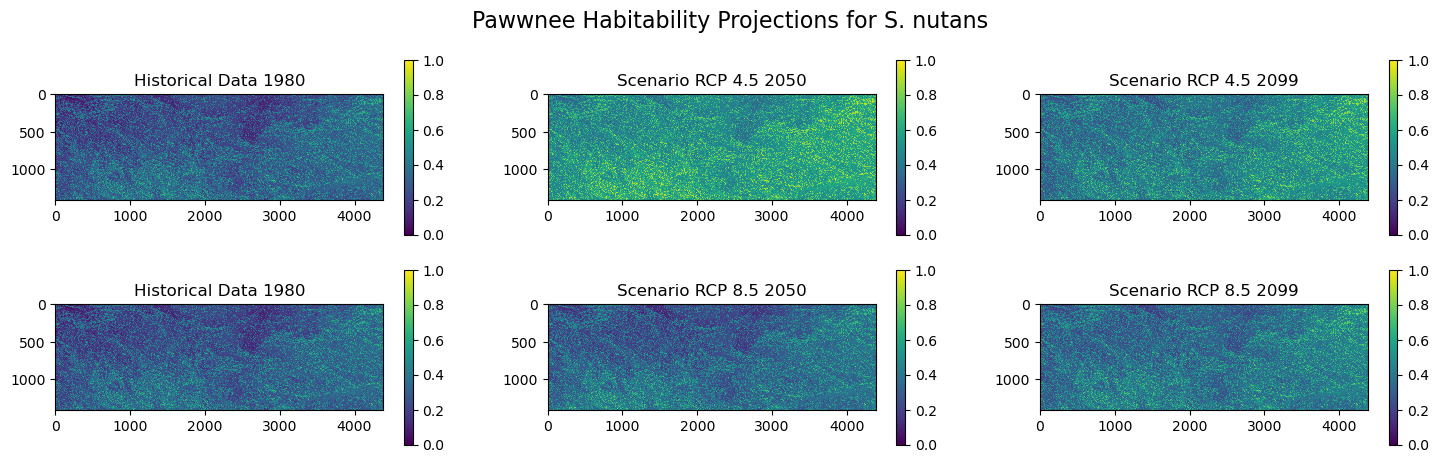

In [37]:
# Read the Pawnee habitability data
historical_data = paw_habitat_suitability_dict["paw_his"]
rcp45_2050_data = paw_habitat_suitability_dict["paw_r45_2050"]
rcp85_2050_data = paw_habitat_suitability_dict["paw_r85_2050"]
rcp45_2099_data = paw_habitat_suitability_dict["paw_r45_2099"]
rcp85_2099_data = paw_habitat_suitability_dict["paw_r85_2099"]

# Create subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 5))
fig.suptitle('Pawwnee Habitability Projections for S. nutans', fontsize=16)

# Plot historical data
cbar = axs[0, 0].imshow(historical_data.values,
                        cmap='viridis',
                        interpolation='none',
                        vmin=0, vmax=1)
axs[0, 0].set_title('Historical Data 1980')
plt.colorbar(cbar, ax=axs[0, 0], orientation='vertical')

# Plot rcp4.5 data for 2050
cbar = axs[0, 1].imshow(rcp45_2050_data.values,
                        cmap='viridis',
                        interpolation='none',
                        vmin=0, vmax=1)
axs[0, 1].set_title('Scenario RCP 4.5 2050')
plt.colorbar(cbar, ax=axs[0, 1], orientation='vertical')

# Plot rcp4.5 data for 2099
cbar = axs[0, 2].imshow(rcp45_2099_data.values,
                        cmap='viridis',
                        interpolation='none',
                        vmin=0, vmax=1)
axs[0, 2].set_title('Scenario RCP 4.5 2099')
plt.colorbar(cbar, ax=axs[0, 2], orientation='vertical')

# Plot historical data
cbar = axs[1, 0].imshow(historical_data.values,
                        cmap='viridis',
                        interpolation='none',
                        vmin=0, vmax=1)
axs[1, 0].set_title('Historical Data 1980')
plt.colorbar(cbar, ax=axs[1, 0], orientation='vertical')

# Plot rcp8.5 data for 2050
cbar = axs[1, 1].imshow(rcp85_2050_data.values, cmap='viridis',
                        interpolation='none',
                        vmin=0, vmax=1)
axs[1, 1].set_title('Scenario RCP 8.5 2050')
plt.colorbar(cbar, ax=axs[1, 1], orientation='vertical')

# Plot rcp8.5 data for 2099
cbar = axs[1, 2].imshow(rcp85_2099_data.values, cmap='viridis',
                        interpolation='none',
                        vmin=0, vmax=1)
axs[1, 2].set_title('Scenario RCP 8.5 2099')
plt.colorbar(cbar, ax=axs[1, 2], orientation='vertical')

# Show the plot
plt.show()

## References Cited:

Bagne, K.; Ford, P.; Reeves, M. (November 2012). Grasslands. U.S. Department of Agriculture, Forest Service, Climate Change Resource Center. www.fs.usda.gov/ccrc/topics/grasslands/

Brakie, M. 2017. Plant Guide for Indiangrass (Sorghastrum nutans). USDA-Natural Resources Conservation Service, East
Texas Plant Materials Center. Nacogdoches, TX 75964.

Elkhart, KS: NOWData - NOAA Online Weather Data Monthly normals. National Weather Service. Retrieved December, 2023, from https://www.weather.gov/wrh/climate?wfo=ddc.

Franklin, S. B., Scheibout, M., & Šibik, J. (2020). Vegetation Classification Exercise for the Pawnee National Grasslands, USA. Vegetation Classification and Survey, 1, 123-137.

Greeley, CO: NOWData - NOAA Online Weather Data Monthly normals. National Weather Service. Retrieved December, 2023, from https://www.weather.gov/wrh/climate?wfo=ddc.

Kuhn, B. (2009). A floristic inventory of the Cimarron National Grassland (Kansas) and the Comanche National Grassland (Colorado) USA. University of Wyoming.

Macleod, C. (2017, January). Sorghastrum nutans, Indian Grass – 4 (4). North American Native Plant Society. https://nanps.org/native_plants_know/sorghastrum-nutans-indian-grass-4-4/#:~:text=Reaching%20depths%20of%20two%20metres,like%20seed%20heads%20called%20panicles

Radić, V., & Clarke, G. K. (2011). Evaluation of IPCC models’ performance in simulating late-twentieth-century climatologies and weather patterns over North America. Journal of climate, 24(20), 5257-5274.

USDA, NRCS. 2017. The PLANTS Database (http://plants.usda.gov, 19 July 2017). National Plant data Team, Greensboro,
NC 27401-4901 USA.
